# IMPORTS FOR COLABORATORY ONLY

In [ ]:
!pip install git+https://github.com/pydata/pandas-datareader.git
!pip install git+https://github.com/scubamut/fintools.git
!pip install cvxopt
!pip install pyfolio
!pip install ffn
!pip install itable

# Imports

In [1]:
from __future__ import print_function
from IPython.utils.path import get_ipython_dir
print(get_ipython().profile_dir.location)
 
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import talib
import itable
import ffn
 
from fintools.Parameters import Parameters
from fintools.set_start_end import set_start_end
from fintools.get_yahoo_prices import get_yahoo_prices
from fintools.compute_weights_RS_DM import compute_weights_RS_DM
from fintools.compute_weights_PMA import compute_weights_PMA
from fintools.endpoints import endpoints
from fintools.backtest import backtest
from fintools.monthly_return_table import monthly_return_table
from fintools.show_return_table import show_return_table
from fintools.finhelpers3 import highlight_pos_neg
 
%matplotlib inline

/home/scubamut/.ipython/profile_default


# STEP BY STEP BACKTEST

## EXAMPLE 1 - single strategy, RS_DM, manual parameters

In [3]:
#*****************************************************************
# Load historical data
#****************************************************************** 
 
frequency = 'M'
    
cash_proxy = 'VUSTX'
risk_free = 0

rs_lookback = 1
risk_lookback = 1
n_top = 3
 
# these are the ETFs used by Systematic Investor (2005 - today)
symbols = ['VCVSX','VWINX','VWEHX','VGHCX','VFIIX','VWAHX','FGOVX','FFXSX']
 
# these funds could be used as proxies for the Philbrick results
#symbols = ['^GSPC', 'VEURX', 'FJPNX', 'FEMKX', 'FRESX','EGLRX', 'VFITX', 'VUSTX', 'VGPMX', 'GOLDX' ]
 
data_path = '/home/scubamut/Projects/DATA'
 
# get data
tickers = symbols.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))
 
# data = pd.DataFrame (columns=tickers)
# for symbol in tickers :
#     url = 'http://chart.finance.yahoo.com/table.csv?s=' + symbol + '&ignore=.csv'
#     data[symbol] = pd.read_csv(url, parse_dates=True, index_col='Date').sort_index(ascending=True)['Adj Close']
 
# Define which online source one should use
data_source = 'yahoo'
 
# We would like all available data from 01/01/2000 until today.
start_date = '2000-01-01'
end_date = datetime.datetime.today().strftime('%Y-%m-%d')
 
# User pandas_reader.data.DataReader to load the desired data.
panel_data = web.DataReader(tickers, data_source, start_date, end_date)
data = panel_data['Adj Close'].sort_index(ascending=True)
 
inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])
 
# print (inception_dates)
 
prices = data.copy().dropna()
 
end_points = endpoints(period=frequency, trading_days=prices.index)
prices_m = prices.loc[end_points]
prices_m[:3]

Symbols,FFXSX,FGOVX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,
1999-12-31,5.503257,4.492321,4.412899,4.341340,26.870892,3.453843,4.365182,2.018928,7.132277
2000-01-31,5.490644,4.487085,4.521092,4.300431,27.895369,3.497043,4.313072,2.003461,7.060387
2000-02-29,5.531670,4.548587,4.999759,4.361311,28.488045,3.600634,4.377412,2.006290,6.848501


In [4]:
returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
absolute_momentum_rule = returns > 0
if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()
    
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

returns[:3]

Symbols,VCVSX,VWINX,VWEHX,VGHCX,VFIIX,VWAHX,FGOVX,FFXSX
Date,,,,,,,,
2000-01-31,0.024517,-0.010080,-0.007661,0.038126,-0.009423,-0.011938,-0.001165,-0.002292
2000-02-29,0.105874,-0.030011,0.001412,0.021246,0.014157,0.014917,0.013706,0.007472
2000-03-31,0.006971,0.056018,-0.009069,0.082158,0.017121,0.023098,0.013909,0.007790


In [5]:
# relative strength ranking               
ranked = excess_returns.loc[rebalance_dates][symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0
elligible[:3]

Symbols,VCVSX,VWINX,VWEHX,VGHCX,VFIIX,VWAHX,FGOVX,FFXSX
Date,,,,,,,,
2000-01-31,True,False,False,True,False,False,True,False
2000-02-29,True,False,False,True,False,True,False,False
2000-03-31,False,True,False,True,False,True,False,False


In [6]:
# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)
elligible[:3]

Symbols,VCVSX,VWINX,VWEHX,VGHCX,VFIIX,VWAHX,FGOVX,FFXSX
Date,,,,,,,,
2000-01-31,0.333333,0.000000,0.0,0.333333,0.0,0.000000,0.333333,0.0
2000-02-29,0.333333,0.000000,0.0,0.333333,0.0,0.333333,0.000000,0.0
2000-03-31,0.000000,0.333333,0.0,0.333333,0.0,0.333333,0.000000,0.0


In [7]:
# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[:10]

Symbols,FFXSX,FGOVX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,
2000-01-31,0.000000,0.000000,0.333333,0.000000,0.333333,0.0,0.000000,0.000000,0.000000
2000-02-29,0.000000,0.000000,0.333333,0.000000,0.333333,0.0,0.333333,0.000000,0.000000
2000-03-31,0.000000,0.000000,0.000000,0.000000,0.333333,0.0,0.333333,0.000000,0.333333
2000-04-28,0.333333,0.000000,0.000000,0.000000,0.333333,0.0,0.000000,0.333333,0.000000
2000-05-31,0.000000,0.000000,0.000000,0.333333,0.333333,0.0,0.000000,0.000000,0.333333
2000-06-30,0.000000,0.000000,0.333333,0.000000,0.333333,0.0,0.333333,0.000000,0.000000
2000-07-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,0.333333,0.333333
2000-08-31,0.000000,0.000000,0.333333,0.000000,0.333333,0.0,0.000000,0.000000,0.333333
2000-09-29,0.000000,0.000000,0.000000,0.333333,0.333333,0.0,0.000000,0.000000,0.333333


In [8]:
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)
weights[:3]

Symbols,FFXSX,FGOVX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,
2000-01-31,0.0,0.0,0.333333,0.0,0.333333,0.333333,0.000000,0.0,0.000000
2000-02-29,0.0,0.0,0.333333,0.0,0.333333,0.000000,0.333333,0.0,0.000000
2000-03-31,0.0,0.0,0.000000,0.0,0.333333,0.000000,0.333333,0.0,0.333333


FIRST BUY DATE = 2000-01-31 00:00:00



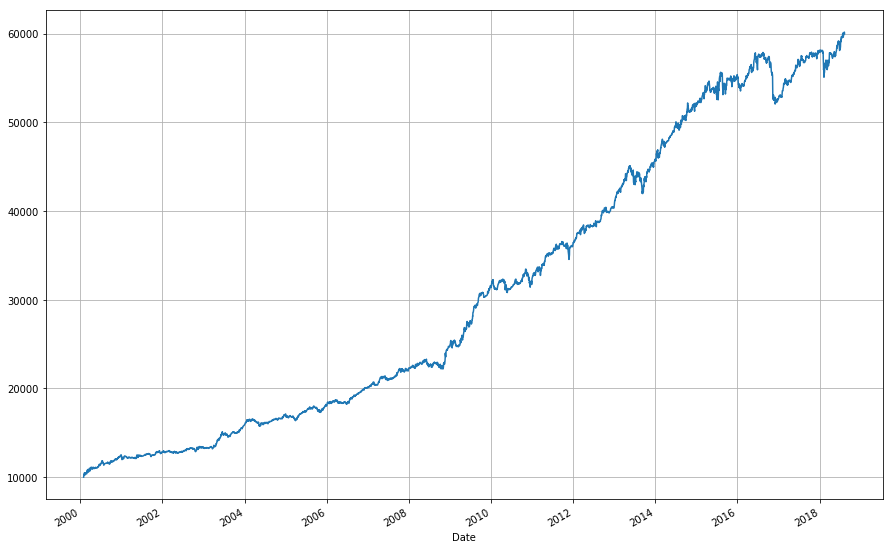

In [9]:
# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

In [10]:
p_weights.loc[rebalance_dates][:3]

Symbols,FFXSX,FGOVX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,
2000-01-31,0.0,0.0,0.333333,0.0,0.333333,0.333333,0.000000,0.0,0.000000
2000-02-29,0.0,0.0,0.333333,0.0,0.333333,0.000000,0.333333,0.0,0.000000
2000-03-31,0.0,0.0,0.000000,0.0,0.333333,0.000000,0.333333,0.0,0.333333


In [11]:
ffn.calc_perf_stats(p_value).display()

Stats for None from 2000-01-31 00:00:00 - 2018-08-10 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
499.74%             1.65  10.15%  -10.05%

Annualized Returns:
mtd    3m     6m     ytd    1y     3y     5y     10y     incep.
-----  -----  -----  -----  -----  -----  -----  ------  --------
0.29%  3.60%  8.58%  3.47%  5.72%  2.70%  6.32%  10.13%  10.15%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.65     1.73       1.34
mean    9.86%    9.84%      9.29%
vol     5.99%    5.68%      6.92%
skew    -0.30    0.42       0.55
kurt    4.27     2.97       1.76
best    2.23%    8.73%      26.85%
worst   -2.66%   -5.54%     -4.65%

Drawdowns:
max      avg       # days
-------  ------  --------
-10.05%  -0.84%     17.94

Misc:
---------------  ------
avg. up month    1.52%
avg. down month  -0.96%
up year %        94.44%
12m up %         95.77%


In [12]:
show_return_table(p_value)

## EXAMPLE 2 - using Parameters, RS_DM

In [13]:
start_date, end_date, data_source

('2000-01-01', '2018-08-13', 'yahoo')

In [14]:
# CHOOSE ONLY ONE

portfolios = {
#     'RS0001': { 'symbols': ['VCVSX','VWEHX','VFIIX','FGOVX','VWAHX'], 
#                'prices':data_source, 'start':start_date, 'end':end_date,
#                'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 2, 'frequency': 'M',
#               'cash_proxy': 'CASHX', 'risk_free': 0},
#     'RS0002': {'symbols': ['MMHYX','FAGIX','VFIIX'], 
#                'prices':data_source, 'start':start_date, 'end':end_date,               
#                'rs_lookback': 3, 'risk_lookback': 2, 'n_top': 1, 'frequency': 'M',
#               'cash_proxy': 'CASHX', 'risk_free': 0},
#     'RS0003': {'symbols': ['MMHYX','FAGIX','VFIIX'], 
#                'prices':data_source, 'start':start_date, 'end':end_date,
#                'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 1, 'frequency': 'Q',
#               'cash_proxy': 'CASHX', 'risk_free': 0},  
    
    'DM0001': {'symbols': ['VCVSX','VWINX','VWEHX','VGHCX','VFIIX','VWAHX','FGOVX','FFXSX'], 
               'prices':data_source, 'start':start_date, 'end':end_date,
               'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 3, 'frequency': 'M',
              'cash_proxy': 'VUSTX', 'risk_free': 0},
    
#     'DM0002': {'symbols': ['VCVSX','VUSTX','VWEHX','VFIIX','VGHCX','FRESX'], 
#                'prices':data_source, 'start':start_date, 'end':end_date,
#                'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 5, 'frequency': 'M',
#               'cash_proxy': 'VFIIX', 'risk_free': 'FFXSX'},
    }

In [15]:
#*****************************************************************
# Load historical data
#****************************************************************** 

name = [i for i in portfolios.items()][0][0]
p = Parameters(portfolios[name])

cash_proxy = p.cash_proxy
risk_free = p.risk_free

rs_lookback = p.rs_lookback
risk_lookback = p.risk_lookback
n_top = p.n_top
# allocations = p.allocations
 
symbols = p.symbols

# User pandas_reader.data.DataReader to load the desired data.
panel_data = web.DataReader(tickers, data_source, start_date, end_date)
data = panel_data['Adj Close'].sort_index(ascending=True)
 
inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])
 
# print (inception_dates)
 
prices = data.copy().dropna()

end_points = endpoints(period=p.frequency, trading_days=prices.index)
prices_m = prices.loc[end_points]

prices_m[:3]

Symbols,FFXSX,FGOVX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,
1999-12-31,5.503257,4.492321,4.412899,4.341340,26.870892,3.453843,4.365182,2.018928,7.132277
2000-01-31,5.490644,4.487085,4.521092,4.300431,27.895369,3.497043,4.313072,2.003461,7.060387
2000-02-29,5.531670,4.548587,4.999759,4.361311,28.488045,3.600634,4.377412,2.006290,6.848501


FIRST BUY DATE = 2000-01-31 00:00:00



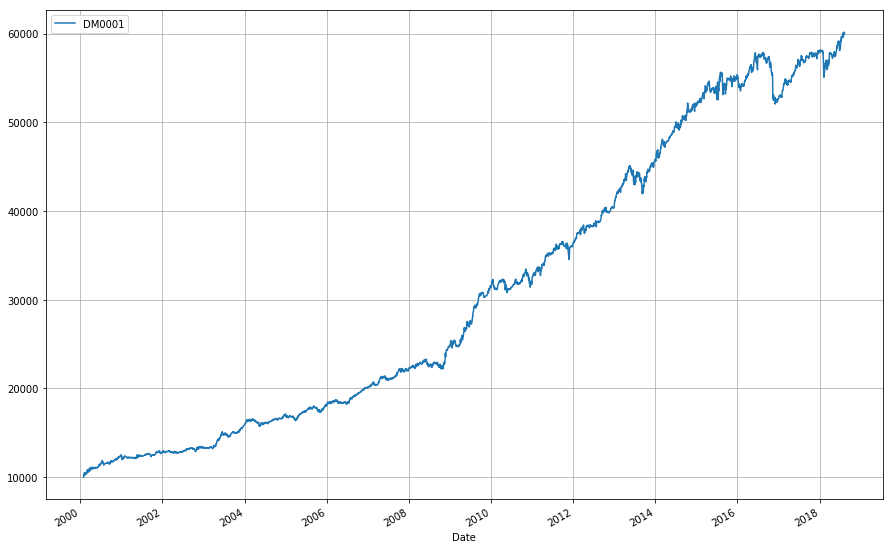

In [16]:
returns = prices_m[p.symbols].pct_change(p.rs_lookback)[p.rs_lookback:]

if isinstance(p.risk_free, int):
    excess_returns = returns
else:
    risk_free_returns = prices_m[p.risk_free].pct_change(p.rs_lookback)[p.rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()

absolute_momentum = prices_m[p.symbols].pct_change(p.risk_lookback)[p.risk_lookback:]
absolute_momentum_rule = absolute_momentum > 0
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

# relative strength ranking
ranked = excess_returns.loc[rebalance_dates][p.symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked <= p.n_top] > 0

# equal weight allocations
elligible = elligible.multiply(1. / elligible.sum(1), axis=0)

# downside protection
weights = pd.DataFrame(0., index=elligible.index, columns=prices.columns)
if p.cash_proxy == 'CASHX':
    weights[p.cash_proxy] = 0
    prices[p.cash_proxy] = 1.
weights[p.symbols] = (elligible * absolute_momentum_rule).dropna()
weights[p.cash_proxy] += 1 - weights[p.symbols].sum(axis=1)

# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15, 10), grid=True, legend=True, label=name)


## EXAMPLE 3 - using Parameters, PMA

In [17]:
start_date, end_date, data_source

('2000-01-01', '2018-08-13', 'yahoo')

In [18]:
# CHOOSE ONLY ONE

portfolios = {
    'PMA001': {'symbols': ['VCVSX', 'VFIIX'], 
               'prices':data_source, 'start':start_date, 'end':end_date,  
               'risk_lookback': 3, 'frequency': 'M', 'allocations': [0.6, 0.4],
              'cash_proxy': 'VUSTX'},
#     'PMA002': {'symbols': ['VCVSX', 'VWINX', 'VWEHX'], 
#                'prices':data_source, 'start':start_date, 'end':end_date,
#                'risk_lookback': 3, 'frequency': 'M', 'allocations': [0.6, 0.2, 0.2],
#               'cash_proxy': 'VUSTX'},
#     'PMA003': {'symbols': ['VCVSX', 'FAGIX', 'VGHCX'], 
#                'prices':data_source, 'start':start_date, 'end':end_date,
#                'risk_lookback': 2, 'frequency': 'M', 'allocations': [1./3., 1./3., 1./3.],
#               'cash_proxy': 'VUSTX'}
    }

In [20]:
#*****************************************************************
# Load historical data
#****************************************************************** 

name = [i for i in portfolios.items()][0][0]
p = Parameters(portfolios[name])

cash_proxy = p.cash_proxy
# risk_free = p.risk_free

# rs_lookback = p.rs_lookback
risk_lookback = p.risk_lookback
# n_top = p.n_top
allocations = p.allocations
 
symbols = p.symbols

# User pandas_reader.data.DataReader to load the desired data.
panel_data = web.DataReader(tickers, data_source, start_date, end_date)
data = panel_data['Adj Close'].sort_index(ascending=True)
 
inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])
 
# print (inception_dates)
 
prices = data.copy().dropna()

end_points = endpoints(period=p.frequency, trading_days=prices.index)
prices_m = prices.loc[end_points]

prices_m[:3]

Symbols,FFXSX,FGOVX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,
1999-12-31,5.503257,4.492321,4.412899,4.341340,26.870892,3.453843,4.365182,2.018928,7.132277
2000-01-31,5.490644,4.487085,4.521092,4.300431,27.895369,3.497043,4.313072,2.003461,7.060387
2000-02-29,5.531670,4.548587,4.999759,4.361311,28.488045,3.600634,4.377412,2.006290,6.848501


FIRST BUY DATE = 2000-02-29 00:00:00



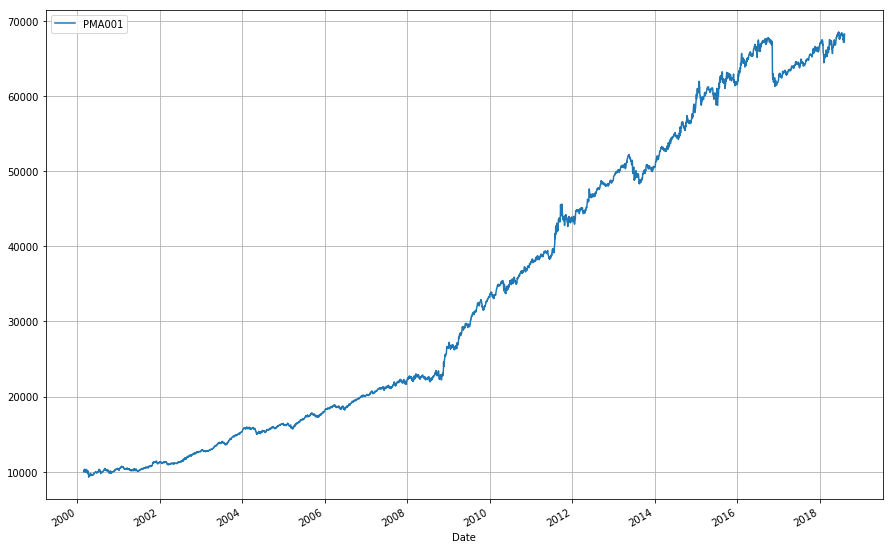

In [21]:
# elligibility rule
SMA = prices_m.rolling(p.risk_lookback).mean().dropna()
rebalance_dates = SMA.index
rule = prices_m.loc[rebalance_dates][p.symbols] > SMA[p.symbols]

# fixed weight allocation
weights = p.allocations * rule

# downside protection
weights[p.cash_proxy] = 1 - weights[p.symbols].sum(axis=1)

# backtest
p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15, 10), grid=True, legend=True, label=name)

# SCRATCH

In [24]:
(10000 * weights.loc[date] / prices.loc[date]).astype(int)

FFXSX      0
FGOVX      0
VCVSX    732
VFIIX      0
VGHCX    116
VUSTX    937
VWAHX      0
VWEHX      0
VWINX      0
Name: 2000-01-31 00:00:00, dtype: int32